In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from yellowbrick.classifier import ConfusionMatrix, ROCAUC
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

In [6]:
test = pd.read_csv("/content/test.csv")
train = pd.read_csv("/content/train.csv")
print("the shape of train dataset :",train.shape)
print("the shape of test dataset :",test.shape)

the shape of train dataset : (140700, 20)
the shape of test dataset : (93800, 19)


* 将train数据集分为student_train和worker_train；分别训练得到两个模型
* 将test数据集分为student_test和worker_test；模型分别预测，最后结果concat一下




In [7]:
worker_train = train[train['Working Professional or Student']=='Working Professional']
student_train = train[train['Working Professional or Student']=='Student']
print("the sum of student_train and worker_train",len(student_train)+len(worker_train))
worker_test = test[test['Working Professional or Student']=='Working Professional']
student_test = test[test['Working Professional or Student']=='Student']
print("the sum of student_test and worker_test",len(student_test)+len(worker_test))

the sum of student_train and worker_train 140700
the sum of student_test and worker_test 93800


In [8]:
#获得student_test和worker_test的索引
student_id = list(student_test['id'])
worker_id = list(worker_test['id'])

# **为了建模：开始处理student_train 和 worker_train**

In [9]:
print("student_train's columns:\n",student_train.columns,"\n")
print("worker_train's columns:\n",worker_train.columns)

student_train's columns:
 Index(['id', 'Name', 'Gender', 'Age', 'City',
       'Working Professional or Student', 'Profession', 'Academic Pressure',
       'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction',
       'Sleep Duration', 'Dietary Habits', 'Degree',
       'Have you ever had suicidal thoughts ?', 'Work/Study Hours',
       'Financial Stress', 'Family History of Mental Illness', 'Depression'],
      dtype='object') 

worker_train's columns:
 Index(['id', 'Name', 'Gender', 'Age', 'City',
       'Working Professional or Student', 'Profession', 'Academic Pressure',
       'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction',
       'Sleep Duration', 'Dietary Habits', 'Degree',
       'Have you ever had suicidal thoughts ?', 'Work/Study Hours',
       'Financial Stress', 'Family History of Mental Illness', 'Depression'],
      dtype='object')


In [10]:
student_train.drop(columns=['id','Name','City','Working Professional or Student','Profession','Work Pressure','Job Satisfaction'],inplace=True)
student_test.drop(columns=['id','Name','City','Working Professional or Student','Profession','Work Pressure','Job Satisfaction'],inplace=True)
worker_test.drop(columns=['id','Name','City','Working Professional or Student','Academic Pressure','CGPA','Study Satisfaction'],inplace=True)
worker_train.drop(columns=['id','Name','City','Working Professional or Student','Academic Pressure','CGPA','Study Satisfaction'],inplace=True)

<ipython-input-10-383bf699114c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  student_train.drop(columns=['id','Name','City','Working Professional or Student','Profession','Work Pressure','Job Satisfaction'],inplace=True)
<ipython-input-10-383bf699114c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  student_test.drop(columns=['id','Name','City','Working Professional or Student','Profession','Work Pressure','Job Satisfaction'],inplace=True)
<ipython-input-10-383bf699114c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pand

In [11]:
student_train.head()

,Gender,Age,Academic Pressure,CGPA,Study Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
2,Male,33.0,5.0,8.97,2.0,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
8,Female,24.0,2.0,5.90,5.0,5-6 hours,Moderate,BSc,No,3.0,2.0,Yes,0
26,Male,31.0,3.0,7.03,5.0,Less than 5 hours,Healthy,BA,No,9.0,1.0,Yes,0
30,Female,28.0,3.0,5.59,2.0,7-8 hours,Moderate,BCA,Yes,4.0,5.0,Yes,1
32,Female,25.0,4.0,8.13,3.0,5-6 hours,Moderate,M.Tech,Yes,1.0,1.0,No,0


**1、先处理Degree这一列**
* 可以写一个函数，然后让4个数据集apply()这个函数。
* 可以看到这一列unique值比较多，怎么处理是关键

In [12]:
combined_degrees = pd.concat([worker_train['Degree'], student_train['Degree']])
degree_counts = combined_degrees.value_counts()
# 筛选 count > 100 的 Degree 值
filtered_degrees = degree_counts[degree_counts > 100]
degree_list = filtered_degrees.index.tolist()
print(degree_list)

['Class 12', 'B.Ed', 'B.Arch', 'B.Com', 'B.Pharm', 'BCA', 'M.Ed', 'MCA', 'BBA', 'BSc', 'MSc', 'LLM', 'M.Pharm', 'M.Tech', 'B.Tech', 'LLB', 'BHM', 'MBA', 'BA', 'ME', 'MD', 'MHM', 'BE', 'PhD', 'M.Com', 'MBBS', 'MA']


In [13]:
student_train['Degree'] = student_train['Degree'].apply(lambda x: x if x in degree_list else 'Unkonwn')
student_test['Degree'] = student_test['Degree'].apply(lambda x: x if x in degree_list else 'Unkonwn')
worker_train['Degree'] = worker_train['Degree'].apply(lambda x: x if x in degree_list else 'Unkonwn')
worker_test['Degree'] = worker_test['Degree'].apply(lambda x: x if x in degree_list else 'Unkonwn')

<ipython-input-13-920ea1c2c71d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  student_train['Degree'] = student_train['Degree'].apply(lambda x: x if x in degree_list else 'Unkonwn')
<ipython-input-13-920ea1c2c71d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  student_test['Degree'] = student_test['Degree'].apply(lambda x: x if x in degree_list else 'Unkonwn')
<ipython-input-13-920ea1c2c71d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

In [14]:
student_train['Degree'].value_counts()

,count
Degree,
Class 12,6080
B.Ed,1867
B.Com,1506
B.Arch,1478
BCA,1433
MSc,1190
B.Tech,1152
MCA,1044
M.Tech,1022


**2、处理Sleep Duration这一列**

In [15]:
student_train['Sleep Duration'].value_counts()

,count
Sleep Duration,
Less than 5 hours,8310
7-8 hours,7346
5-6 hours,6183
More than 8 hours,6044
6-7 hours,4
10-11 hours,2
2-3 hours,2
3-4 hours,2
1-2 hours,1


In [16]:
def categorize_sleep_duration(duration):
    if isinstance(duration, str):  # Check if the data is a string
        if 'Less than 5' in duration or '1-5' in duration or '3-4' in duration or '4-5' in duration:
            return 'Less than 5 hours'
        elif '5-6' in duration or '6-7' in duration or '4-6' in duration:
            return '5-6 hours'
        elif '7-8' in duration or '6-8' in duration:
            return '7-8 hours'
        elif 'More than 8' in duration or '8-9' in duration or '9-11' in duration or '10-11' in duration:
            return 'More than 8 hours'
    # Return 'Unknown' for invalid or inconsistent values
    return 'Unknown'
# Preprocess Sleep Duration for the Students group (Train)
student_train['Sleep Duration'] = student_train['Sleep Duration'].apply(categorize_sleep_duration)

# Preprocess Sleep Duration for the Workers group (Train)
worker_train['Sleep Duration'] = worker_train['Sleep Duration'].apply(categorize_sleep_duration)
# Preprocess Sleep Duration for the Students group (Train)
student_test['Sleep Duration'] = student_test['Sleep Duration'].apply(categorize_sleep_duration)

# Preprocess Sleep Duration for the Workers group (Train)
worker_test['Sleep Duration'] = worker_test['Sleep Duration'].apply(categorize_sleep_duration)


<ipython-input-16-79e8cb86b857>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  student_train['Sleep Duration'] = student_train['Sleep Duration'].apply(categorize_sleep_duration)
<ipython-input-16-79e8cb86b857>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  worker_train['Sleep Duration'] = worker_train['Sleep Duration'].apply(categorize_sleep_duration)
<ipython-input-16-79e8cb86b857>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

In [17]:
student_train['Sleep Duration'].value_counts()

,count
Sleep Duration,
Less than 5 hours,8313
7-8 hours,7346
5-6 hours,6188
More than 8 hours,6046
Unknown,8


**3、处理Dietary Habits这一列**

In [18]:
student_train['Dietary Habits'].value_counts()

,count
Dietary Habits,
Unhealthy,10317
Moderate,9921
Healthy,7651
3,1
Less than Healthy,1
Mihir,1
1.0,1
No Healthy,1
Less Healthy,1


In [19]:
valid_categories = ['Healthy', 'Moderate', 'Unhealthy']
# prompt: create a map that could transform 'Less than healthy' and 'No healthy' into 'Unhealthy'

mapping = {
    'Less than healthy': 'Unhealthy',
    'No healthy': 'Unhealthy',
    'Less Healthy':'Unhealthy'
}

student_train['Dietary Habits'] = student_train['Dietary Habits'].replace(mapping)
student_test['Dietary Habits'] = student_test['Dietary Habits'].replace(mapping)
worker_train['Dietary Habits'] = worker_train['Dietary Habits'].replace(mapping)
worker_test['Dietary Habits'] = worker_test['Dietary Habits'].replace(mapping)

<ipython-input-19-dc0aabd68b49>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  student_train['Dietary Habits'] = student_train['Dietary Habits'].replace(mapping)
<ipython-input-19-dc0aabd68b49>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  student_test['Dietary Habits'] = student_test['Dietary Habits'].replace(mapping)
<ipython-input-19-dc0aabd68b49>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


In [20]:
# Clean 'Dietary Habits' in the Students group (Train)
student_train['Dietary Habits'] = student_train['Dietary Habits'].apply(
    lambda x: x if x in valid_categories else 'Unhealthy'
)
student_test['Dietary Habits'] = student_test['Dietary Habits'].apply(
    lambda x: x if x in valid_categories else 'Unhealthy'
)
worker_train['Dietary Habits'] = worker_train['Dietary Habits'].apply(
    lambda x: x if x in valid_categories else 'Unhealthy'
)
worker_test['Dietary Habits'] = worker_test['Dietary Habits'].apply(
    lambda x: x if x in valid_categories else 'Unhealthy'
)

<ipython-input-20-6b9a78cf8fca>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  student_train['Dietary Habits'] = student_train['Dietary Habits'].apply(
<ipython-input-20-6b9a78cf8fca>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  student_test['Dietary Habits'] = student_test['Dietary Habits'].apply(
<ipython-input-20-6b9a78cf8fca>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

In [21]:
student_train['Dietary Habits'].value_counts()

,count
Dietary Habits,
Unhealthy,10329
Moderate,9921
Healthy,7651


**4、处理train中的student和worker的缺失值**

* student_train、student_test这个数据集中的"Academic Pressure"和"CGPA"
和"Study Satisfaction"空值用mean填充
* worker_train、worker_test这个数据集"Work Pressure"和
"Job Satisfaction"，"Financial Stress"空值用mean填充，"Profession"用Unknown填充

In [22]:
student_train.isnull().sum()

,0
Gender,0
Age,0
Academic Pressure,9
CGPA,9
Study Satisfaction,10
Sleep Duration,0
Dietary Habits,0
Degree,0
Have you ever had suicidal thoughts ?,0
Work/Study Hours,0


In [23]:
worker_train["Work Pressure"].fillna(worker_train["Work Pressure"].mean(),inplace=True)
worker_train["Job Satisfaction"].fillna(worker_train["Job Satisfaction"].mean(),inplace=True)
worker_train["Financial Stress"].fillna(worker_train["Financial Stress"].mean(),inplace=True)
worker_train["Profession"].fillna("Unknown",inplace=True)
worker_test["Work Pressure"].fillna(worker_test["Work Pressure"].mean(),inplace=True)
worker_test["Job Satisfaction"].fillna(worker_test["Job Satisfaction"].mean(),inplace=True)
worker_test["Profession"].fillna("Unknown",inplace=True)

<ipython-input-23-be9dd01c0dbf>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  worker_train["Work Pressure"].fillna(worker_train["Work Pressure"].mean(),inplace=True)
<ipython-input-23-be9dd01c0dbf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  worker_train["Work Pressure"].fillna(worker_train["Work Pressure"].mean(),inplace=True)
<ipytho

In [24]:
student_train["Academic Pressure"].fillna(student_train["Academic Pressure"].mean(),inplace=True)
student_train["CGPA"].fillna(student_train["CGPA"].mean(),inplace=True)
student_train["Study Satisfaction"].fillna(student_train["Study Satisfaction"].mean(),inplace=True)
student_train["Financial Stress"].fillna(student_train["Financial Stress"].mean(),inplace=True)
student_test["Academic Pressure"].fillna(student_test["Academic Pressure"].mean(),inplace=True)
student_test["CGPA"].fillna(student_test["CGPA"].mean(),inplace=True)
student_test["Study Satisfaction"].fillna(student_test["Study Satisfaction"].mean(),inplace=True)

<ipython-input-24-25ac33aa62e7>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  student_train["Academic Pressure"].fillna(student_train["Academic Pressure"].mean(),inplace=True)
<ipython-input-24-25ac33aa62e7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  student_train["Academic Pressure"].fillna(student_train["Academic Pressure"].mean(),i

**5、编码**


In [25]:
label_encoder = LabelEncoder()
student_train['Gender'] = label_encoder.fit_transform(student_train['Gender'])
student_train['Degree'] = label_encoder.fit_transform(student_train['Degree'])
student_train['Sleep Duration'] = label_encoder.fit_transform(student_train['Sleep Duration'])
student_train['Dietary Habits'] = label_encoder.fit_transform(student_train['Dietary Habits'])
student_train['Have you ever had suicidal thoughts ?'] = label_encoder.fit_transform(student_train['Have you ever had suicidal thoughts ?'])
student_train['Family History of Mental Illness'] = label_encoder.fit_transform(student_train['Family History of Mental Illness'])
student_test['Gender'] = label_encoder.fit_transform(student_test['Gender'])
student_test['Degree'] = label_encoder.fit_transform(student_test['Degree'])
student_test['Sleep Duration'] = label_encoder.fit_transform(student_test['Sleep Duration'])
student_test['Dietary Habits'] = label_encoder.fit_transform(student_test['Dietary Habits'])
student_test['Have you ever had suicidal thoughts ?'] = label_encoder.fit_transform(student_test['Have you ever had suicidal thoughts ?'])
student_test['Family History of Mental Illness'] = label_encoder.fit_transform(student_test['Family History of Mental Illness'])

<ipython-input-25-8d4a29fe983b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  student_train['Gender'] = label_encoder.fit_transform(student_train['Gender'])
<ipython-input-25-8d4a29fe983b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  student_train['Degree'] = label_encoder.fit_transform(student_train['Degree'])
<ipython-input-25-8d4a29fe983b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

In [26]:
combined_profession = pd.concat([worker_train['Profession'],worker_test['Profession']])
filter = combined_profession.value_counts()
profession_list = filter.index.tolist()
worker_train['Profession'] = worker_train['Profession'].apply(lambda x: x if x in profession_list else 'Unknown')
worker_test['Profession'] = worker_test['Profession'].apply(lambda x: x if x in profession_list else 'Unknown')

<ipython-input-26-22206ec8fc80>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  worker_train['Profession'] = worker_train['Profession'].apply(lambda x: x if x in profession_list else 'Unknown')
<ipython-input-26-22206ec8fc80>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  worker_test['Profession'] = worker_test['Profession'].apply(lambda x: x if x in profession_list else 'Unknown')


In [27]:
worker_train['Gender'] = label_encoder.fit_transform(worker_train['Gender'])
worker_train['Degree'] = label_encoder.fit_transform(worker_train['Degree'])
worker_train['Sleep Duration'] = label_encoder.fit_transform(worker_train['Sleep Duration'])
worker_train['Dietary Habits'] = label_encoder.fit_transform(worker_train['Dietary Habits'])
worker_train['Have you ever had suicidal thoughts ?'] = label_encoder.fit_transform(worker_train['Have you ever had suicidal thoughts ?'])
worker_train['Family History of Mental Illness'] = label_encoder.fit_transform(worker_train['Family History of Mental Illness'])
worker_train['Profession'] = label_encoder.fit_transform(worker_train['Profession'])
worker_test['Profession'] = label_encoder.fit_transform(worker_test['Profession'])
worker_test['Gender'] = label_encoder.fit_transform(worker_test['Gender'])
worker_test['Degree'] = label_encoder.fit_transform(worker_test['Degree'])
worker_test['Sleep Duration'] = label_encoder.fit_transform(worker_test['Sleep Duration'])
worker_test['Dietary Habits'] = label_encoder.fit_transform(worker_test['Dietary Habits'])
worker_test['Family History of Mental Illness'] = label_encoder.fit_transform(worker_test['Family History of Mental Illness'])
worker_test['Have you ever had suicidal thoughts ?'] = label_encoder.fit_transform(worker_test['Have you ever had suicidal thoughts ?'])

<ipython-input-27-f6601c7f41bf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  worker_train['Gender'] = label_encoder.fit_transform(worker_train['Gender'])
<ipython-input-27-f6601c7f41bf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  worker_train['Degree'] = label_encoder.fit_transform(worker_train['Degree'])
<ipython-input-27-f6601c7f41bf>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

**6、模型**

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [29]:
X_s = student_train.drop(columns='Depression')
y_s = student_train['Depression']
scaler = MinMaxScaler()
norm_x_s = scaler.fit_transform(X_s)
X_norm = pd.DataFrame(norm_x_s, columns=list(X_s.columns))
x_train1, x_test1, y_train1, y_test1 = train_test_split(X_norm, y_s, test_size = 0.2, random_state = 0)


In [30]:
test_s = scaler.fit_transform(student_test)
test_s = pd.DataFrame(test_s, columns=list(student_test.columns))
test_w = scaler.fit_transform(worker_test)
test_w = pd.DataFrame(test_w, columns=list(worker_test.columns))

In [31]:
test_w.head()

,Gender,Age,Profession,Work Pressure,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness
0,1.0,0.833333,0.419355,0.25,1.00,0.50,0.5,0.444444,0.0,0.75,0.50,1.0
1,0.0,0.952381,0.290323,0.25,0.75,0.50,0.5,0.074074,0.0,0.50,0.75,0.0
2,1.0,0.833333,0.870968,0.75,0.00,0.25,0.5,0.000000,1.0,1.00,0.75,0.0
3,1.0,0.690476,0.870968,1.00,1.00,0.25,0.5,0.259259,1.0,0.25,0.75,0.0
4,1.0,0.261905,0.225806,0.25,0.50,0.75,0.5,0.037037,0.0,0.25,0.25,1.0


6.1、逻辑回归

,Solver,penalty,C,Accuracy,Precision,Recall,True Negatives,False Positives,False Negatives,True Positives
0,sag,l2,1,0.855761,0.865453,0.891244,1875,451,354,2901
1,saga,l2,3,0.855761,0.865672,0.890937,1876,450,355,2900
2,liblinear,l2,1,0.855581,0.864760,0.891859,1872,454,352,2903
3,saga,l2,6,0.855581,0.865632,0.890630,1876,450,356,2899
4,saga,l2,5,0.855581,0.865632,0.890630,1876,450,356,2899
...,...,...,...,...,...,...,...,...,...,...
115,newton-cg,None,2,0.855223,0.865333,0.890323,1875,451,357,2898
116,newton-cg,None,7,0.855223,0.865333,0.890323,1875,451,357,2898
117,newton-cg,None,3,0.855223,0.865333,0.890323,1875,451,357,2898
118,newton-cg,None,4,0.855223,0.865333,0.890323,1875,451,357,2898



 the best result is for sag Solver , penalty : l2 and C : 1 which has accuracy of : 0.8557606163769934




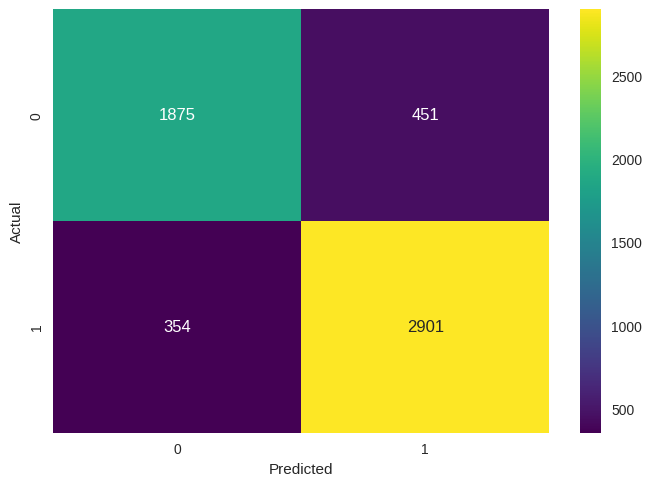

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


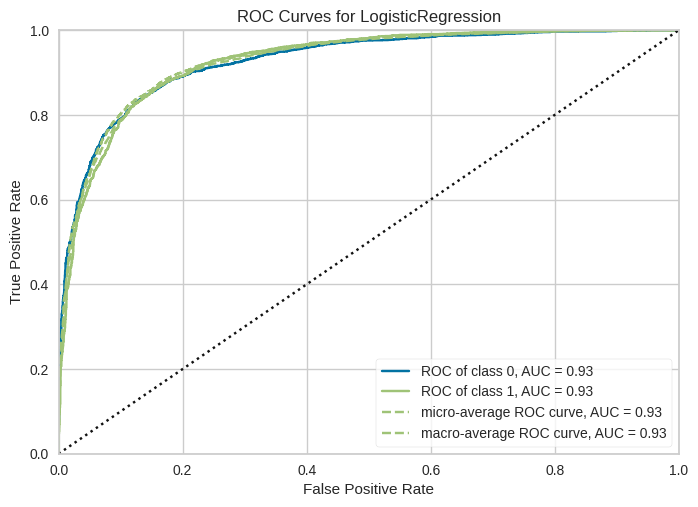

In [32]:
solver_penalties = [
    ('lbfgs', ['l2', None]),
    ('liblinear', ['l1', 'l2']),
    ('newton-cg', ['l2', None]),
    ('sag', ['l2', None]),
    ('saga', ['elasticnet', 'l1', 'l2', None])
]
results = []
for solver, penalties in solver_penalties:
    for C in np.arange(1,11):

        for penalty in penalties:
            if penalty == 'elasticnet':
                l1_ratio = 0.5
                clf = LogisticRegression(solver=solver, C=C, random_state=0,
                                         penalty=penalty, l1_ratio=l1_ratio, max_iter=10000)
            elif penalty is None:
                clf = LogisticRegression(solver=solver, random_state=0, max_iter=10000, penalty= None)
            else:
                clf = LogisticRegression(solver=solver, C=C, random_state=0, penalty=penalty, max_iter=10000)
            clf.fit(x_train1, y_train1)
            y_pred1 = clf.predict(x_test1)
            cm = metrics.confusion_matrix(y_test1, y_pred1)
            accuracy = metrics.accuracy_score(y_test1, y_pred1)
            precision = metrics.precision_score(y_test1, y_pred1)
            recall = metrics.recall_score(y_test1, y_pred1)
            results.append((solver, penalty, C, accuracy, precision, recall, cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]))


results_df = pd.DataFrame(results, columns=['Solver', 'penalty', 'C', 'Accuracy', 'Precision', 'Recall', 'True Negatives',
                                            'False Positives', 'False Negatives', 'True Positives'])

results_df.sort_values(by = 'Accuracy', ascending=False, inplace =True)
results_df.reset_index(drop = True, inplace =True)
display(results_df)

print(f'\n the best result is for {results_df["Solver"][0]} Solver , penalty : {results_df["penalty"][0]} and C : {results_df["C"][0]} which has accuracy of :', results_df['Accuracy'][0])
print('\n')

sns.heatmap([[results_df['True Negatives'][0], results_df['False Positives'][0]],
             [results_df['False Negatives'][0], results_df['True Positives'][0]]], annot=True, fmt='d', cmap='viridis')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

best_solver = results_df["Solver"][0]
best_student_clf = LogisticRegression(solver=best_solver, max_iter=1000, C=10, random_state=0)
best_student_clf.fit(x_train1, y_train1)
y_pred_best = best_student_clf.predict(x_test1)

visualizer = ROCAUC(best_student_clf)
visualizer.fit(x_train1, y_train1)
visualizer.score(x_test1, y_test1)
visualizer.show();

In [33]:
X_w = worker_train.drop(columns='Depression')
y_w = worker_train['Depression']
scaler = MinMaxScaler()
norm_x_w = scaler.fit_transform(X_w)
X_norm_w = pd.DataFrame(norm_x_w, columns=list(X_w.columns))
x_train2, x_test2, y_train2, y_test2 = train_test_split(X_norm_w, y_w, test_size = 0.2, random_state = 0)


,Solver,penalty,C,Accuracy,Precision,Recall,True Negatives,False Positives,False Negatives,True Positives
0,lbfgs,l2,1,0.959885,0.815282,0.661812,20428,278,627,1227
1,liblinear,l2,3,0.959840,0.814324,0.662352,20426,280,626,1228
2,liblinear,l1,2,0.959796,0.813784,0.662352,20425,281,626,1228
3,liblinear,l1,3,0.959796,0.813784,0.662352,20425,281,626,1228
4,liblinear,l1,4,0.959796,0.813784,0.662352,20425,281,626,1228
...,...,...,...,...,...,...,...,...,...,...
115,liblinear,l2,1,0.959707,0.813953,0.660734,20426,280,629,1225
116,lbfgs,l2,2,0.959663,0.813830,0.660194,20426,280,630,1224
117,saga,l2,1,0.959574,0.813582,0.659115,20426,280,632,1222
118,newton-cg,l2,1,0.959574,0.813582,0.659115,20426,280,632,1222



 the best result is for lbfgs Solver , penalty : l2 and C : 1 which has accuracy of : 0.9598847517730497




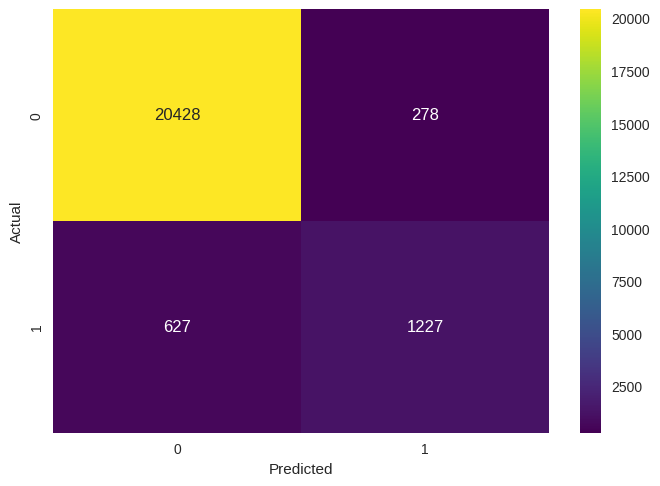

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


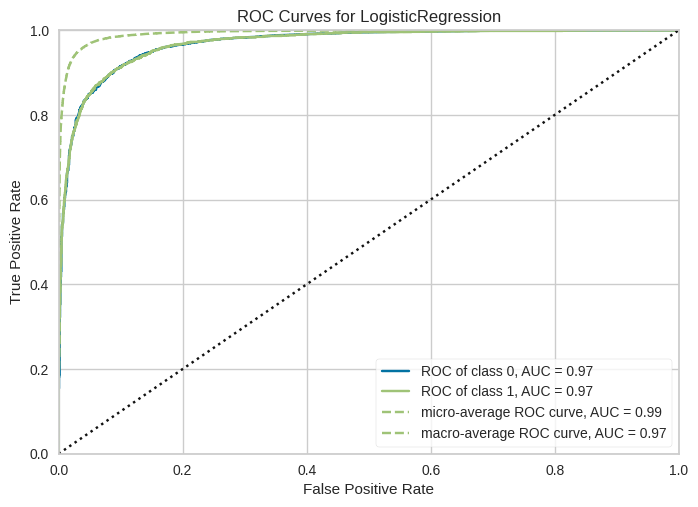

In [34]:
solver_penalties = [
    ('lbfgs', ['l2', None]),
    ('liblinear', ['l1', 'l2']),
    ('newton-cg', ['l2', None]),
    ('sag', ['l2', None]),
    ('saga', ['elasticnet', 'l1', 'l2', None])
]
results = []
for solver, penalties in solver_penalties:
    for C in np.arange(1,11):

        for penalty in penalties:
            if penalty == 'elasticnet':
                l1_ratio = 0.5
                clf = LogisticRegression(solver=solver, C=C, random_state=0,
                                         penalty=penalty, l1_ratio=l1_ratio, max_iter=10000)
            elif penalty is None:
                clf = LogisticRegression(solver=solver, random_state=0, max_iter=10000, penalty= None)
            else:
                clf = LogisticRegression(solver=solver, C=C, random_state=0, penalty=penalty, max_iter=10000)
            clf.fit(x_train2, y_train2)
            y_pred2 = clf.predict(x_test2)
            cm = metrics.confusion_matrix(y_test2, y_pred2)
            accuracy = metrics.accuracy_score(y_test2, y_pred2)
            precision = metrics.precision_score(y_test2, y_pred2)
            recall = metrics.recall_score(y_test2, y_pred2)
            results.append((solver, penalty, C, accuracy, precision, recall, cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]))


results_df = pd.DataFrame(results, columns=['Solver', 'penalty', 'C', 'Accuracy', 'Precision', 'Recall', 'True Negatives',
                                            'False Positives', 'False Negatives', 'True Positives'])

results_df.sort_values(by = 'Accuracy', ascending=False, inplace =True)
results_df.reset_index(drop = True, inplace =True)
display(results_df)

print(f'\n the best result is for {results_df["Solver"][0]} Solver , penalty : {results_df["penalty"][0]} and C : {results_df["C"][0]} which has accuracy of :', results_df['Accuracy'][0])
print('\n')

sns.heatmap([[results_df['True Negatives'][0], results_df['False Positives'][0]],
             [results_df['False Negatives'][0], results_df['True Positives'][0]]], annot=True, fmt='d', cmap='viridis')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

best_solver = results_df["Solver"][0]
best_worker_clf = LogisticRegression(solver=best_solver, max_iter=1000, C=10, random_state=0)
best_worker_clf.fit(x_train2, y_train2)
y_pred_best = best_worker_clf.predict(x_test2)

visualizer = ROCAUC(best_worker_clf)
visualizer.fit(x_train2, y_train2)
visualizer.score(x_test2, y_test2)
visualizer.show();

In [35]:
student_pred = best_student_clf.predict(test_s)
worker_pred = best_worker_clf.predict(test_w)
student_results = pd.DataFrame({
    'id': student_id,      # 学生ID
    'Predicted': student_pred     # 学生预测结果
})
worker_results = pd.DataFrame({
    'id': worker_id,       # 工作者 ID
    'Predicted': worker_pred      # 工作者预测结果
})

In [36]:
# 合并两个结果
combined_results = pd.concat([student_results, worker_results], axis=0)
combined_results = combined_results.sort_values(by='id')
# 保存为 CSV 文件
combined_results.to_csv('submission2.csv', index=False)  # 保存文件时不需要索引

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:57:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


0.8462641103744849 0.8580818643561399


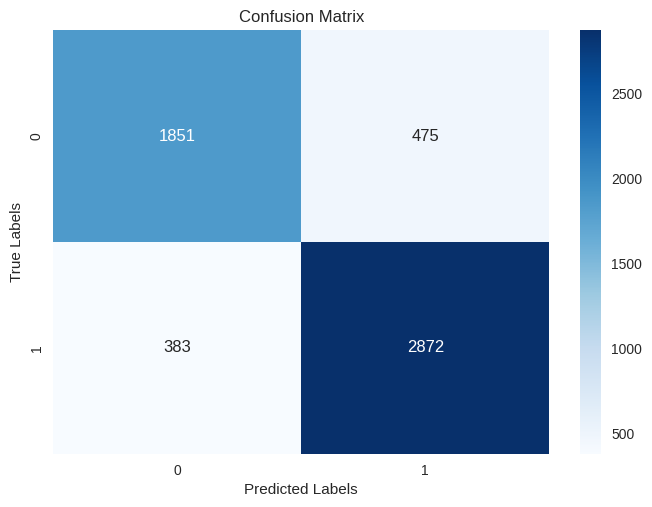

In [39]:
from xgboost import XGBClassifier
import xgboost as xgb
xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'use_label_encoder': False,
}

# Train XGBoost
xgb_model_s = xgb.XGBClassifier(**xgb_params)
xgb_model_s.fit(x_train1, y_train1)
y_pred_xgb_s = xgb_model_s.predict(x_test1)

# Evaluate XGBoost
cm_xgb = metrics.confusion_matrix(y_test1, y_pred_xgb_s)
accuracy_xgb = metrics.accuracy_score(y_test1, y_pred_xgb_s)
precision_xgb = metrics.precision_score(y_test1, y_pred_xgb_s)
print(accuracy_xgb,precision_xgb)
sns.heatmap(cm_xgb,cmap='Blues',cbar=True,annot=True,fmt="d")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:58:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


0.9599290780141844 0.7994955863808323


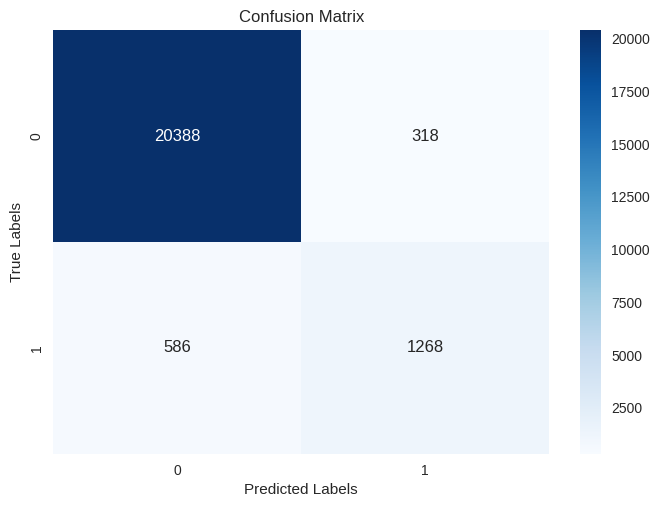

In [41]:
# Train XGBoost
xgb_model_w = xgb.XGBClassifier(**xgb_params)
xgb_model_w.fit(x_train2, y_train2)
y_pred_xgb_w = xgb_model_w.predict(x_test2)

# Evaluate XGBoost
cm_xgb = metrics.confusion_matrix(y_test2, y_pred_xgb_w)
accuracy_xgb = metrics.accuracy_score(y_test2, y_pred_xgb_w)
precision_xgb = metrics.precision_score(y_test2, y_pred_xgb_w)
print(accuracy_xgb,precision_xgb)
sns.heatmap(cm_xgb,cmap='Blues',cbar=True,annot=True,fmt="d")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [42]:
student_pred = xgb_model_s.predict(test_s)
worker_pred = xgb_model_w.predict(test_w)
student_results = pd.DataFrame({
    'id': student_id,      # 学生ID
    'Predicted': student_pred     # 学生预测结果
})
worker_results = pd.DataFrame({
    'id': worker_id,       # 工作者 ID
    'Predicted': worker_pred      # 工作者预测结果
})

In [43]:
# 合并两个结果
combined_results = pd.concat([student_results, worker_results], axis=0)
combined_results = combined_results.sort_values(by='id')
# 保存为 CSV 文件
combined_results.to_csv('submission.csv', index=False)  # 保存文件时不需要索引

In [45]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

base_estimator = DecisionTreeClassifier(max_depth=2)
ada_clf_s = AdaBoostClassifier(estimator=base_estimator,
    n_estimators=300,  # 300 个弱分类器
    learning_rate=0.1, # 学习率
    random_state=42,
)
ada_clf_w = AdaBoostClassifier(estimator=base_estimator,
    n_estimators=300,  # 300 个弱分类器
    learning_rate=0.1, # 学习率
    random_state=42,
)
ada_clf_s.fit(x_train1, y_train1)
ada_clf_w.fit(x_train2, y_train2)
ada_clf_s_pred = ada_clf_s.predict(x_test1)
ada_clf_w_pred = ada_clf_w.predict(x_test2)
accuracy1 = metrics.accuracy_score(y_test1, ada_clf_s_pred)
accuracy2 = metrics.accuracy_score(y_test2, ada_clf_w_pred)
precision1 = metrics.precision_score(y_test1, ada_clf_s_pred)
precision2 = metrics.precision_score(y_test2, ada_clf_w_pred)
print("Student and worker's accuracy:",accuracy1,accuracy2)
print("Student and worker's precision:",precision1,precision2)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


0.8586274861135997 0.961613475177305


In [ ]:
student_pred = ada_clf_s.predict(test_s)
worker_pred = ada_clf_w.predict(test_w)
student_results = pd.DataFrame({
    'id': student_id,      # 学生ID
    'Predicted': student_pred     # 学生预测结果
})
worker_results = pd.DataFrame({
    'id': worker_id,       # 工作者 ID
    'Predicted': worker_pred      # 工作者预测结果
})

In [ ]:
# 合并两个结果
combined_results = pd.concat([student_results, worker_results], axis=0)
combined_results = combined_results.sort_values(by='id')
# 保存为 CSV 文件
combined_results.to_csv('submission3.csv', index=False)  # 保存文件时不需要索引